In [17]:
# A whole new big mess of a step...
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model running via: {device}")

Model running via: cuda


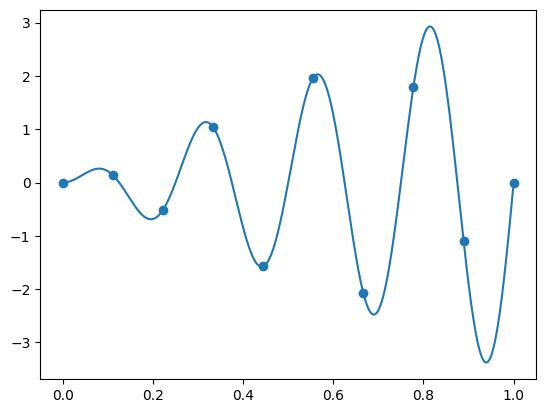

In [19]:
# Globally Shared Model(s) Parameters
hf_num_epochs = 1000

hidden_dims = ([1000, 1000, 1000, 1000, 1000, 1000, 1000])
LF_training_size = 20
HF_training_size = 10


# Synthetic data function..
def LF(x):
    return torch.sin(x * (8 * np.pi))*x
    return 0.5 * (6 * x - 2)**2 * np.sin(12 * x - 4) + 10 * (x - 0.5) - 5

def HF(x): 
    return 1.8*torch.sin(x * (8 * np.pi))*2*x 
    return (6 * x - 2)**2 * np.sin(12 * x - 4) 


# Run this through the model to get the black prediction line
# (predictionu bundan al)
Z = torch.linspace(0, 1, 1000)[:,None]

# Model's total training/val/testing dataset
LF_TS = torch.linspace(0, 1, LF_training_size)[:,None]
HF_TS = torch.linspace(0, 1, HF_training_size)[:,None]

# Forming LF Test Sets with a neat trick
X_LF_train, X_LF_test, Y_LF_train, Y_LF_test = train_test_split(LF_TS, LF(LF_TS), test_size=0.8, shuffle=156)
X_HF_train, X_HF_test, Y_HF_train, Y_HF_test = train_test_split(HF_TS, HF(HF_TS), test_size=0.8, shuffle=156)

# Forming the real equally spaced training sets
X_LF_train = LF_TS
Y_LF_train = LF(LF_TS) 

X_HF_train = HF_TS
Y_HF_train = HF(HF_TS)

plt.plot(Z ,HF(Z))
plt.scatter(X_HF_train, Y_HF_train)

# Transfering data to GPU for CUDA
X_LF_train = X_LF_train.to(device); Y_LF_train = Y_LF_train.to(device)
X_HF_train = X_HF_train.to(device); Y_HF_train = Y_HF_train.to(device)

X_LF_test = X_LF_test.to(device); Y_LF_test = Y_LF_test.to(device)
X_HF_test = X_HF_test.to(device); Y_HF_test = Y_HF_test.to(device)

In [20]:
import torch
import torch.nn as nn

input_dim = 1
output_dim = 1

class SkipConnectionNetwork(torch.nn.Module):
  def __init__(self, hidden_dims, input_dim, output_dim):
    super().__init__()
    
    self.fc1 = nn.utils.weight_norm(nn.Linear(input_dim, hidden_dims[0]))
    self.bn1 = nn.BatchNorm1d(hidden_dims[0], eps=1e-05, momentum=0.1)
    self.fc2 = nn.utils.weight_norm(nn.Linear(hidden_dims[0], hidden_dims[1]))
    self.fc3 = nn.utils.weight_norm(nn.Linear(hidden_dims[1], hidden_dims[2]))
    self.fc4 = nn.utils.weight_norm(nn.Linear(hidden_dims[2], hidden_dims[3]))
    self.fcEND = nn.utils.weight_norm(nn.Linear(hidden_dims[3], output_dim))

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    skip_connection = x
    x = self.bn1(x)
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = x + skip_connection
    x = self.fcEND(x)
    return x

model = SkipConnectionNetwork(hidden_dims, input_dim, output_dim).to(device)

for param in model.parameters():
    param.requires_grad = True

In [21]:
# Training
HF_losses = [] 
val_losses = []
prev_loss = []
HF_loss = torch.zeros(1)

HF_batch_size = 10

# HF_loss criterion and optimizer
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # weight_decay=1e-5

for epoch in range(hf_num_epochs):

    model.train()
    prev_loss = HF_loss.item()
    y_pred = model(X_HF_train.to(device))
    Y_HF_train = Y_HF_train.reshape(*X_HF_train.shape)
    HF_loss = criterion(y_pred, Y_HF_train.to(device))
    HF_losses.append(HF_loss.item())
    optimizer.zero_grad()
    HF_loss.backward()
    optimizer.step()


    # Validation
    shuffled_indices_val = torch.randperm(X_HF_test.size(0))
    X_HF_test = X_HF_test[shuffled_indices_val]
    Y_HF_test = Y_HF_test[shuffled_indices_val]
    num_batches_val = X_HF_test.size(0) // HF_batch_size
    for batch in range(num_batches_val):
        start = batch * HF_batch_size
        end = start + HF_batch_size
        X_batch = X_HF_test[start:end]
        Y_batch = Y_HF_test[start:end]
    ### Training
    val_outputs = model(X_HF_test)
    val_loss = criterion(val_outputs, Y_HF_test)
    val_losses.append(val_loss.item())
    
    if (epoch+1) % 600 == 0:
        print(f'Epoch [{epoch+1}/{hf_num_epochs}], Loss: {HF_loss.item():.4f}')

    current_loss = HF_loss.item()
    if abs(current_loss - prev_loss) < 1e-9:
        a = 1
        
params = list(model.parameters()) # weight values
print(params[0].size())

Epoch [600/1000], Loss: 0.0000
torch.Size([1000])


Error: 47.952473529300235
Epochs needed (out of 1000): 1000
LF Training Loss: 4.790455477632349e-06


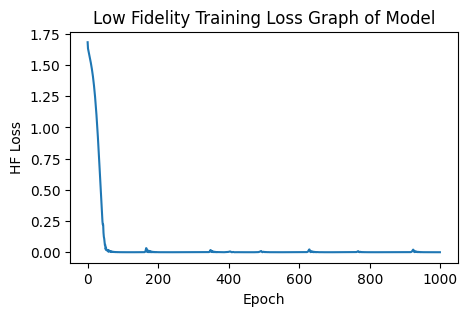

In [22]:
# Calculating Error of model via valiation set
percentage_errors = []

for i in range(len(HF_losses)):
    abs_error = ((abs(HF_losses[i] - val_losses[i]))/2)
    percentage_error = (abs_error / val_losses[i]) * 100
    percentage_errors.append(percentage_error)
LF_average_percentage_error = sum(percentage_errors) / len(percentage_errors)

plt.figure(figsize=(5,3))
plt.plot(HF_losses, label = "Training")
plt.xlabel('Epoch')
plt.ylabel('HF Loss')
plt.title('Low Fidelity Training Loss Graph of Model')

# plt.plot(val_losses, "--" , label = "Testing")
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Low Fidelity Validation Loss Graph of Model')
# plt.legend(loc='upper right')
# # plt.show()

print(f"Error: {LF_average_percentage_error}")
print(f"Epochs needed (out of {hf_num_epochs}): {len(HF_losses)}")
print(f"LF Training Loss: {HF_loss}")

In [23]:
model.eval()

for layer in model.modules():
    if isinstance(layer, torch.nn.BatchNorm2d):
        layer.eval()

# Define the NEW input data
with torch.no_grad(): 
    # Y_test_prediction = LF_model(X_LF_test.to(device)) # Testing Data
    y_HF_pred = model(Z.to(device))

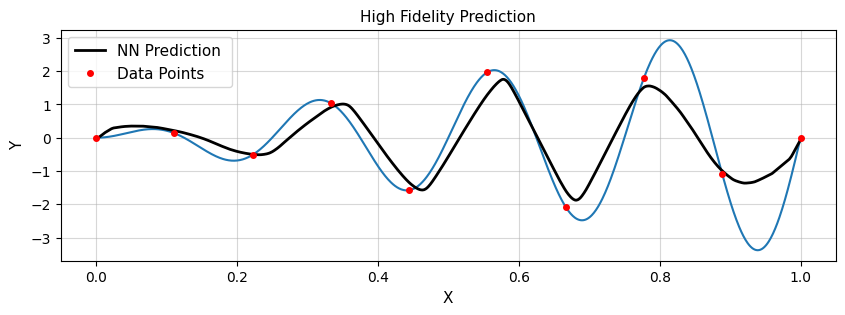

In [24]:
# Low Fidelity Model
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(Z, HF(Z))
ax.plot(Z.cpu().detach().numpy(), y_HF_pred.cpu().detach().numpy(),'k', lw=2, label= "NN Prediction ")
ax.plot(X_HF_train.cpu().detach().numpy(), Y_HF_train.cpu().detach().numpy(), 'ro', markersize = 4, label = 'Data Points')
ax.grid(which='both', alpha=0.5)
ax.set_xlabel('X', fontsize=11)
ax.set_ylabel('Y', fontsize=11)
ax.set_title('High Fidelity Prediction', fontsize=11)
ax.legend(loc='best', ncol=1, fontsize=11)
plt.show()



# # Generate a grid of values in 2D
# x = np.linspace(-5, 5, 100)
# y = np.linspace(-5, 5, 100)
# X, Y = np.meshgrid(x, y)
# Z = np.zeros_like(X)
# plt.contour(X,Y,Z)
# plt.show()
